## GAN with Sign Language Dataset

**Imports**

In [1]:
import tensorflow as tf
import numpy as np
import zipfile
import urllib
from IPython import display
import matplotlib.pyplot as plt
from tqdm import tqdm

**Load and Process the Dataset**

In [2]:
data_url="https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/signs-training.zip"
data_file_name="archive.zip"
urllib.request.urlretrieve(data_url, data_file_name)

training_dir="/tmp/signs/"
zip_ref = zipfile.ZipFile(data_file_name, "r")
zip_ref.extractall(training_dir)
zip_ref.close()

In [15]:
def process_image(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_png(img)
  img = tf.cast(img, tf.float32)/127.5 -1

  return img

In [16]:
batch_size=128

In [17]:
dataset_paths=tf.data.Dataset.list_files("/tmp/signs/signs-training/*.png", shuffle=True, seed=123) #shuffle=True: default
train_dataset=(dataset_paths
               .map(process_image)
               .batch(batch_size, drop_remainder=True)
               .prefetch(tf.data.experimental.AUTOTUNE))

In [18]:
len(dataset_paths)

27455

In [19]:
for exam in train_dataset.take(1):
  print(exam.shape)

(128, 28, 28, 1)


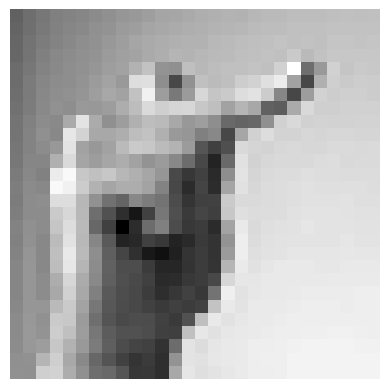

In [23]:
plt.imshow(exam[0], cmap="gray")
plt.axis("off");

**Build the Generator**

In [88]:
z_dim=128

In [89]:
tf.keras.backend.clear_session()

In [90]:
def model_generator(input_shape=(1, 1, z_dim)):
  input=tf.keras.Input(shape=input_shape)
  x=tf.keras.layers.Conv2DTranspose(256, (7,7), strides=1, padding="valid", use_bias=False)(input)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.ReLU()(x)

  x=tf.keras.layers.Conv2DTranspose(128, (4,4), strides=2, padding="same", use_bias=False)(x)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.ReLU()(x)

  x=tf.keras.layers.Conv2DTranspose(1, (4,4), strides=2, padding="same")(x)
  x=tf.keras.layers.Activation("tanh")(x)

  model=tf.keras.Model(inputs=input, outputs=x, name="generator")

  return model

In [91]:
generator=model_generator()
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 1, 128)]       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 256)         1605632   
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 7, 7, 256)         1024      
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 14, 14, 128)       524288    
 Transpose)                                                      
                                                         

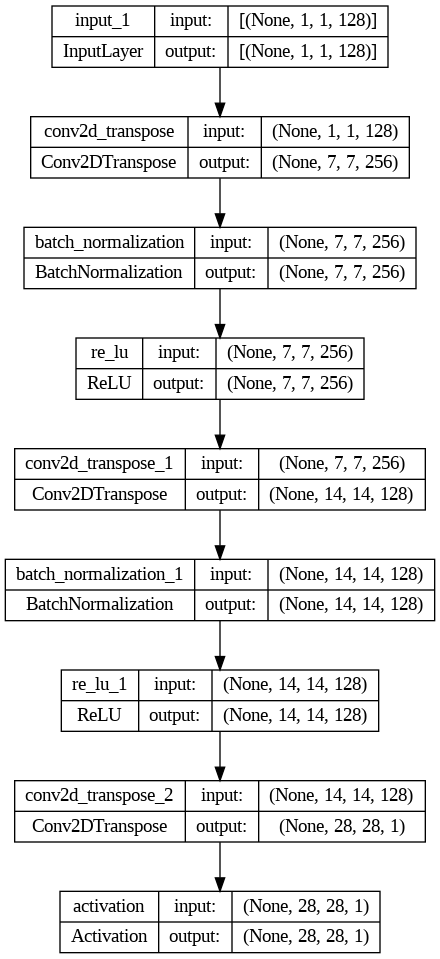

In [92]:
tf.keras.utils.plot_model(generator, show_shapes=True, show_layer_names=True)

**Build the Discriminator**

In [93]:
def model_discriminator(input_shape=(28, 28, 1)):
  input=tf.keras.Input(shape=input_shape)
  x=tf.keras.layers.Conv2D(128, (4,4), strides=2, padding="same")(input)
  x=tf.keras.layers.LeakyReLU(0.2)(x)

  x=tf.keras.layers.Conv2D(256, (4,4), strides=2, padding="same", use_bias=False)(x)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.LeakyReLU(0.2)(x)

  x=tf.keras.layers.Conv2D(1, (7,7), strides=1, padding="valid")(x)

  model=tf.keras.Model(inputs=input, outputs=x, name="discriminator")

  return model

In [94]:
discriminator=model_discriminator()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       2176      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 256)         524288    
                                                                 
 batch_normalization_2 (Bat  (None, 7, 7, 256)         1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 256)         0         
                                                     

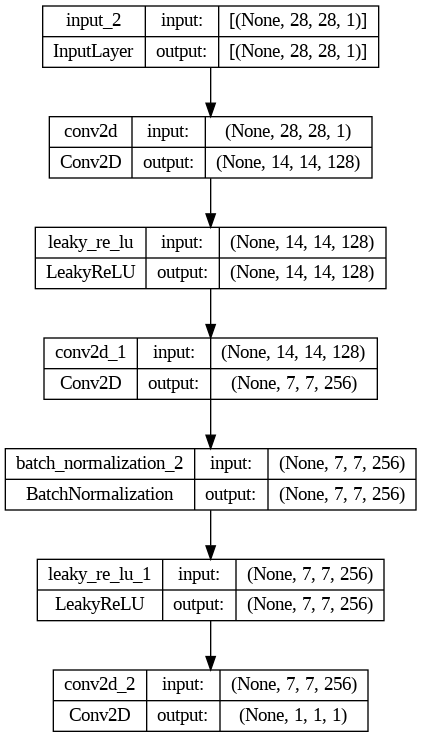

In [95]:
tf.keras.utils.plot_model(discriminator, show_shapes=True, show_layer_names=True)

**Training Model**

In [96]:
optimizer_g=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizer_d=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)

In [97]:
def train_on_batch(real_images):

  # Train the discriminator
  with tf.GradientTape() as d_tape:
    noise=tf.random.normal(shape=(batch_size, 1, 1, z_dim))
    fake_images=generator(noise)
    fake_out=discriminator(fake_images)
    real_out=discriminator(real_images)

    fake_loss=loss(tf.zeros_like(fake_out), fake_out)
    real_loss=loss(tf.ones_like(real_out), real_out)
    d_loss=tf.reduce_mean(real_loss + fake_loss)

  d_gradients=d_tape.gradient(d_loss, discriminator.trainable_variables)
  optimizer_d.apply_gradients(zip(d_gradients, discriminator.trainable_variables))

  # Train the generator
  with tf.GradientTape() as g_tape:
    noise=tf.random.normal(shape=(batch_size, 1, 1, z_dim))
    fake_images=generator(noise)
    fake_out=discriminator(fake_images)

    fake_loss=loss(tf.ones_like(fake_out), fake_out)
    g_loss=tf.reduce_mean(fake_loss)

  g_gradients=g_tape.gradient(g_loss, generator.trainable_variables)
  optimizer_g.apply_gradients(zip(g_gradients, generator.trainable_variables))

  return d_loss, g_loss

In [98]:
epochs=50

In [99]:
# Display function

def plot_images(images, title="", cmap=None):
  display.clear_output(wait=False)

  # Denormalization
  images=tf.clip_by_value((images+1)*127.5, 0, 255)
  images=tf.cast(images, dtype=tf.uint8).numpy()

  num_cols, num_rows = int(images.shape[0]**0.5), int(images.shape[0]**0.5)
  plt.figure(figsize=(num_cols, num_rows))
  plt.suptitle(title)
  for i in range(len(images)):
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(images[i], cmap=cmap)
    plt.axis("off")

  plt.show()

In [100]:
# Training function
def train_gan(num_examples=64):
  test_z = tf.random.normal(shape=(num_examples, 1, 1, z_dim))

  for epoch in range(epochs):
    with tqdm(train_dataset) as pbar:
      pbar.set_description(f"[Epoch {epoch+1}]")
      for batch_images in pbar:
        d_loss, g_loss = train_on_batch(batch_images)
        pbar.set_postfix({"g_loss": g_loss.numpy(), "d_loss": d_loss.numpy()})

    fake_images=generator(test_z)
    plot_images(fake_images, title=f"Epoch {epoch+1}/{epochs}", cmap="gray")

    if (d_loss<0.01) and (g_loss<0.01):
      print(f"Training is over! d_loss:{d_loss} and g_loss:{g_loss} are less than 0.01")
      break

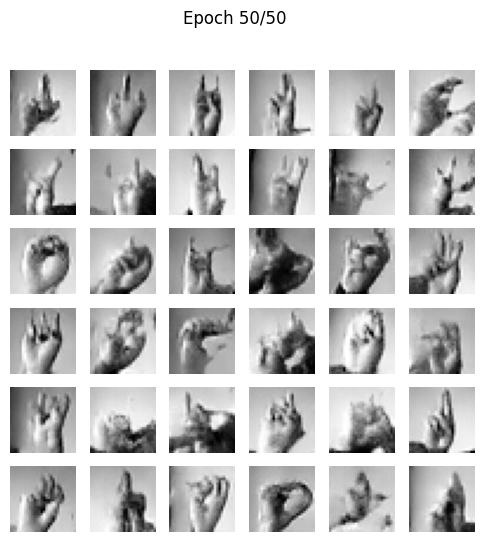

In [101]:
tf.random.set_seed(123)

train_gan(num_examples=36)

**Generate Examples**

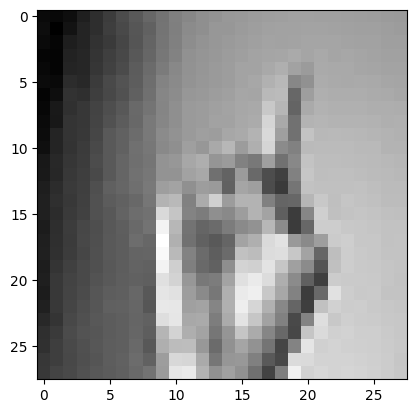

In [106]:
example=tf.random.normal(shape=(1, 1, 1, z_dim))
generated_example=generator(example)
plt.imshow(generated_example.numpy().squeeze(), cmap="gray");